In [1]:
using Random
using Distributions
using LinearAlgebra
include("../Inversion/Plot.jl")
include("../Inversion/KalmanInversion.jl")
include("../Inversion/RWMCMC.jl")
include("../Inversion/SMC.jl")

┌ Info: Precompiling Distributions [31c24e10-a181-5473-b8eb-7969acd0382f]
└ @ Base loading.jl:1423


SMC_Run (generic function with 1 method)

# Nonlinear 1-Parameter Model Problem
The posterior distribution is studied  numerically on the following nonlinear 1-parameter problems:

* Exponential problem:

     \begin{equation*}
    y = \mathcal{G}(\theta) + \eta \qquad \mathcal{G}(\theta) = \exp\Big(\frac{\theta}{10}\Big).
    \end{equation*}
    
* Quadratic multimodal problem:

    \begin{equation*}
    y = \mathcal{G}(\theta) + \eta \qquad \mathcal{G}(\theta) = \theta^2. 
    \end{equation*}
    
* Cubic problem:

     \begin{equation*}
    y = \mathcal{G}(\theta) + \eta \qquad \mathcal{G}(\theta) = \theta^3. 
    \end{equation*}
    
* Sign discontinuous problem:

     \begin{equation*}
    y = \mathcal{G}(\theta) + \eta \qquad \mathcal{G}(\theta) = \textrm{sign}(\theta) + \theta^3. 
    \end{equation*}
    
* Hyperbola discontinuous problem:

     \begin{equation*}
    y = \mathcal{G}(\theta) + \eta \qquad \mathcal{G}(\theta) = \frac{1}{\theta}.
    \end{equation*}

We assume the observation is generated as $y = \mathcal{G}(\theta_{ref})$, where the reference solution $\theta_{ref} = 2$.
And the observation error is 

$$\eta \sim \mathcal{N}(0, 0.1^2).$$ 

For Bayesian inverse problems, we assume the prior distribution is $\mathcal{N}(-1, 10^2)$, where the prior mean $-1$ is on a different branch for these discontinuous problems.  It is worth noticing, for these inverse problems, the observation error is small, and the prior is almost uninformative. However, $\mathcal{G}$ is not injective for the quadratic multimodal problem, and the Lipschitz property does not hold for these discontinuous problems.

In [2]:
mutable struct Setup_Param{IT<:Int}
    θ_names::Array{String,1}
    N_θ::IT
    N_y::IT
end

function Setup_Param(N_θ::IT, N_y::IT) where {IT<:Int}
    return Setup_Param(["θ"], N_θ, N_y)
end


Setup_Param

# Numerical Methods

The posterior distribution is approximated by 
* MCMC method (reference):  a step size $1.0$ and $5\times10^6$ samples (with a $10^6$ sample burn-in period).
* SMC method: $10^3$ particles and $10^2$ uniform steps is also applied for comparison. 
* UKI method: $2$ initial conditions are considered, which are $\theta_0\sim\mathcal{N}(-1, 0.5^2)$ and $\theta_0\sim\mathcal{N}(1, 0.5^2)$. We find that only the hyperbola discontinuous problem is sensitive to the initial covariance for the UKI. The hyperparameters of UKI are chosen at the $n$-th iteration, as following
$$ r = r_0 \quad
    \Sigma_{\nu} = 2\Sigma_{\eta} \quad \textrm{ and } \quad \Sigma_{\omega} =  C_n
$$
here $r_0$ is the prior mean. It is worth mentioning the artificial evolution error covariance $\Sigma_{\omega}$ is updated as the estimated covariance $C_{n}$.

In [18]:
function Posterior_Plot(forward::Function, uki_plot::Array{Bool,1} = [true; true])
    s_param = Setup_Param(1, 1)
    y = forward(s_param, [2.0;])
    Σ_η = reshape([0.1^2], (1,1))
    
    # prior distribution
    μ0,  Σ0   = [-1.0;], reshape([10^2.0],  (1, 1))
    θ0_mean⁻, θθ0_cov⁻  = [-1.0;], reshape([0.5^2],  (1, 1))
    θ0_mean⁺, θθ0_cov⁺  = [ 1.0;], reshape([0.5^2],  (1, 1))
    
    
    
    # compute posterior distribution by MCMC
    logρ(θ) = log_bayesian_posterior(s_param, θ, forward, y, Σ_η, μ0, Σ0) 
    step_length = 1.0
    N_iter , n_burn_in= 5000000, 1000000
    us = RWMCMC_Run(logρ, μ0, step_length, N_iter)
 
    
    # compute posterior distribution by SMC
    N_ens = 1000
    M_threshold = Float64(N_ens)
    N_t = 100
    step_length = 1.0
    smcobj = SMC_Run(s_param, forward,
    μ0, Σ0, 
    y, Σ_η,
    N_ens, 
    step_length,
    M_threshold,
    N_t) 
    
    # compute posterior distribution by UKI
    update_freq = 1
    α_reg,  N_iter = 1.0, 20
    ukiobj⁻ = UKI_Run(s_param, forward, θ0_mean⁻, θθ0_cov⁻, y, Σ_η, α_reg, update_freq, N_iter)
    ukiobj⁺ = UKI_Run(s_param, forward, θ0_mean⁺, θθ0_cov⁺, y, Σ_η, α_reg, update_freq, N_iter)
    
    
    # visualization 
    nrows, ncols = 1, 1
    fig, ax = PyPlot.subplots(nrows=nrows, ncols=ncols, sharex=true, sharey=true, figsize=(6,6))
    
    # plot UKI results 
    for i in [1; 2]
        if i == 1
            ukiobj, marker, linestyle, label, color = ukiobj⁻ , "o", "-", "UKI (m₀=-1)" , "C1"
        else
            ukiobj, marker, linestyle, label, color =  ukiobj⁺, "*", ":", "UKI (m₀=1)" , "C2"
        end
        Nx = 1000
        xx, zz = Gaussian_1d(ukiobj.θ_mean[end][1], ukiobj.θθ_cov[end][1,1], Nx)
        
        if uki_plot[i]
            ax.plot(xx, zz, marker= marker,linestyle=linestyle, color=color, fillstyle="none", markevery=100, label=label)
        end
    end
    
    
    
    # plot MCMC results 
    ax.hist(us[n_burn_in:end, 1], bins = 100, density = true, histtype = "step", label="MCMC", color="C3")
    
    
    # plot SMC results 
    θ = smcobj.θ[end]
    weights = smcobj.weights[end]
    ax.hist(θ, bins = 20, weights = weights, density = true, histtype = "step", label="SMC", color="C0")
    
    
    ax.legend()
    
    
end


Posterior_Plot (generic function with 2 methods)

## Exponential problem:

$$y = \mathcal{G}(\theta) + \eta \qquad \mathcal{G}(\theta) = \exp\Big(\frac{\theta}{10}\Big)$$
The true posterior distribution has skewness, which cannot be captured by Gaussian distribution.

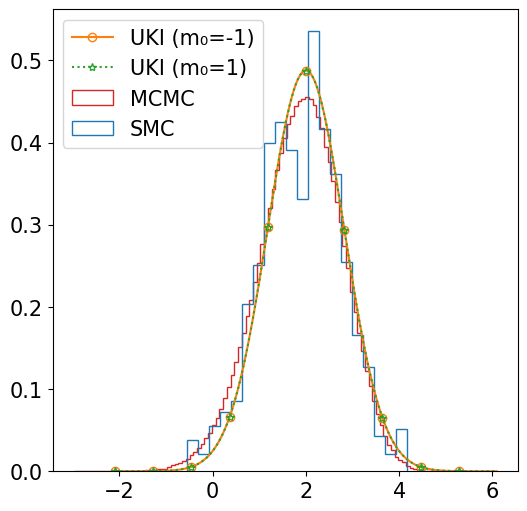

PyObject <matplotlib.legend.Legend object at 0x7fdc82116ad0>

In [19]:
function exp10(s_param, θ::Array{Float64,1})  
    return [exp(θ[1]/10.0) ;]
end

Posterior_Plot(exp10)

## Quadratic multimodal problem:
$$
    y = \mathcal{G}(\theta) + \eta \qquad \mathcal{G}(\theta) = \theta^2. 
$$

The true posterior distribution has two modals, since $\mathcal{G}^{-1}(y) =  \pm \sqrt{|y|}$. 

The Gaussian approximation obtained by UKI can only capture one modal, 
that is close to the initial condition $\theta_0$

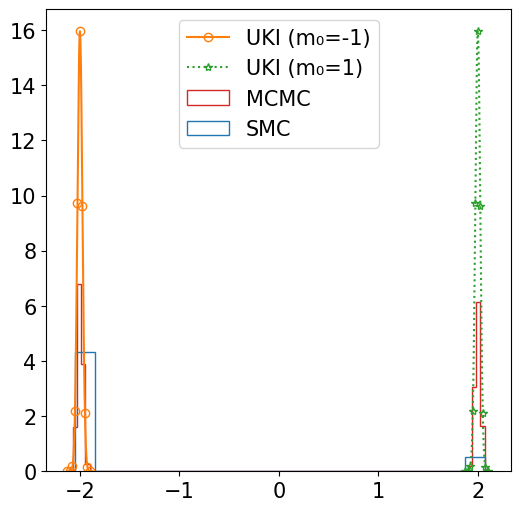

PyObject <matplotlib.legend.Legend object at 0x7fdc99fcdbd0>

In [20]:
function p2(s_param, θ::Array{Float64,1})  
    return [θ[1]^2 ;]
end

Posterior_Plot(p2) 

## Cubic problem:

$$
    y = \mathcal{G}(\theta) + \eta \qquad \mathcal{G}(\theta) = \theta^3. 
$$

The true posterior distribution is very "Gaussian".  


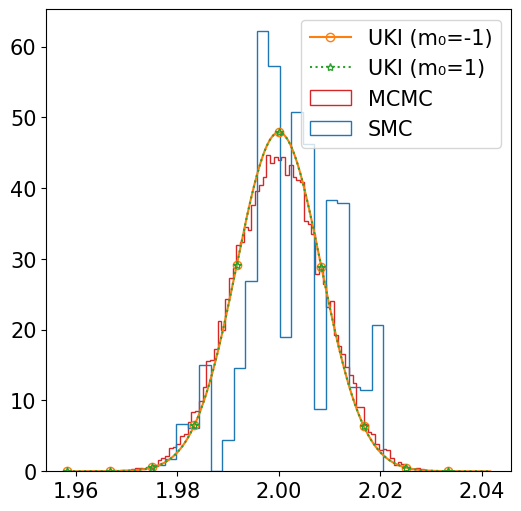

PyObject <matplotlib.legend.Legend object at 0x7fdca80aea90>

In [21]:
function p3(s_param, θ::Array{Float64,1})  
    return [θ[1]^3 ;]
end

Posterior_Plot(p3)

## Sign discontinuous problem:

$$
    y = \mathcal{G}(\theta) + \eta \qquad \mathcal{G}(\theta) = \textrm{sign}(\theta) + \theta^3. 
$$
    
The true posterior distribution is almost identical to that of the cubic problem.

Adding the term $\textrm{sign}(\theta)$ does not affect the posterior distribution. 
Adding 


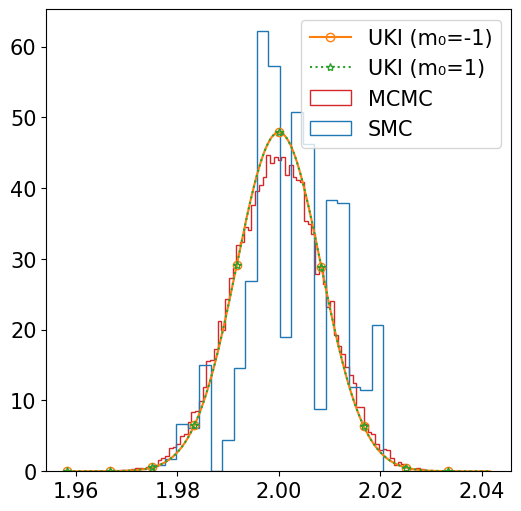

PyObject <matplotlib.legend.Legend object at 0x7fdc881ee210>

In [22]:
function signp3(s_param, θ::Array{Float64,1})  
    return [sign(θ[1]) + θ[1]^3 ;]
    
end

Posterior_Plot(signp3)

## Hyperbola discontinuous problem:

$$
    y = \mathcal{G}(\theta) + \eta \qquad \mathcal{G}(\theta) = \frac{1}{\theta}.
$$

This problem has a singularity at $\theta = 0$, and the true posterior distribution features strong skewness.
Despite of these challenges, SMC and MCMC deliver similar results.
The UKI initialized on the different branch from $\theta_{ref}$ diverges to $-\infty$; 
but the UKI initialized on the same branch from $\theta_{ref}$ converges to $\theta_{ref}$ 
with good covariance estimation. 

This reveals the gradient-based nature of UKI, in contrast to the sampling-based nature of MCMC or SMC.

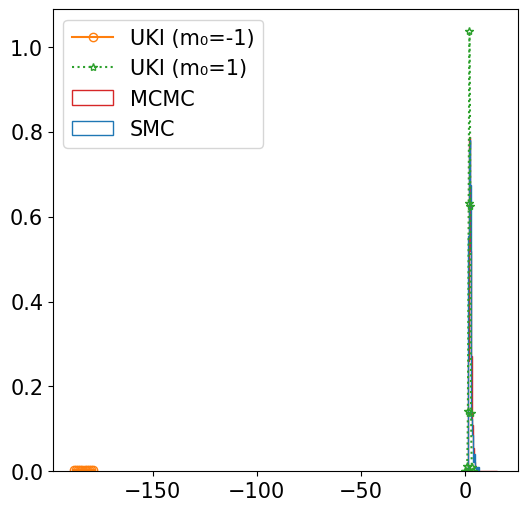

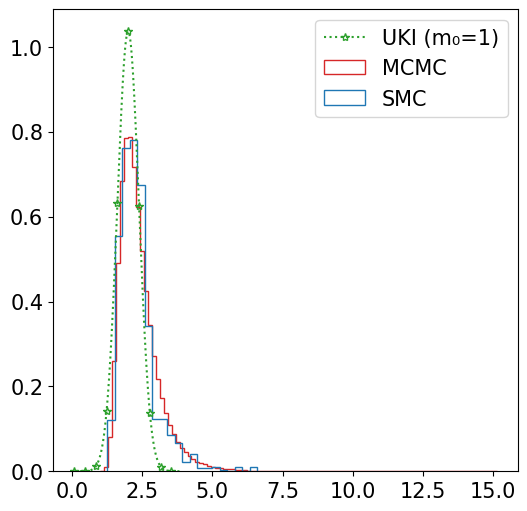

PyObject <matplotlib.legend.Legend object at 0x7fdc825146d0>

In [23]:
function xinv(s_param, θ::Array{Float64,1})  
    return [1.0/θ[1] ;]
    
end

Posterior_Plot(xinv)
Posterior_Plot(xinv, [false, true])